In [1]:
import pandas as pd
import pickle

In [27]:
with open("../btc_usd_1d.pkl","rb") as fr:
    data = pickle.load(fr)
print(data)

                   o         h         l         c             v
ot                                                              
2014-11-29    376.42    386.60    372.25    376.72  2.746157e+06
2014-11-30    376.57    381.99    373.32    373.34  1.145567e+06
2014-12-01    376.40    382.31    373.03    378.39  2.520662e+06
2014-12-02    378.39    382.86    375.23    379.25  2.593576e+06
2014-12-03    379.25    383.00    374.23    376.67  2.998358e+06
...              ...       ...       ...       ...           ...
2022-01-20  41733.21  43518.69  40554.14  40736.05  2.425153e+03
2022-01-21  40654.72  41115.58  35423.00  36495.46  6.201046e+03
2022-01-22  36447.37  36825.98  34000.00  35091.11  4.510372e+03
2022-01-23  35084.79  36574.47  34624.59  36293.62  2.533704e+03
2022-01-24  36262.21  36276.86  35917.44  35917.44  3.775357e+01

[2614 rows x 5 columns]


In [37]:
data

,Open,High,Low,Close,Volume
ot,,,,,
2014-11-29,376.42,386.60,372.25,376.72,2.746157e+06
2014-11-30,376.57,381.99,373.32,373.34,1.145567e+06
2014-12-01,376.40,382.31,373.03,378.39,2.520662e+06
2014-12-02,378.39,382.86,375.23,379.25,2.593576e+06
2014-12-03,379.25,383.00,374.23,376.67,2.998358e+06
...,...,...,...,...,...
2022-01-20,41733.21,43518.69,40554.14,40736.05,2.425153e+03
2022-01-21,40654.72,41115.58,35423.00,36495.46,6.201046e+03
2022-01-22,36447.37,36825.98,34000.00,35091.11,4.510372e+03


In [36]:
data.columns = ['Open','High','Low','Close','Volume']

In [38]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(data[scale_cols])
scaled

array([[3.18199066e-03, 2.52605283e-03, 3.32614195e-03, 3.18589848e-03,
        3.55568085e-03],
       [3.18421666e-03, 2.45903451e-03, 3.34233013e-03, 3.13574788e-03,
        1.48326158e-03],
       [3.18169386e-03, 2.46368654e-03, 3.33794268e-03, 3.21067703e-03,
        3.26371389e-03],
       ...,
       [5.38474529e-01, 5.32267068e-01, 5.12085159e-01, 5.18259121e-01,
        5.83995879e-06],
       [5.18253856e-01, 5.28610717e-01, 5.21534670e-01, 5.36101310e-01,
        3.28059996e-06],
       [5.35726757e-01, 5.24284183e-01, 5.41094382e-01, 5.30519756e-01,
        4.88827305e-08]])

In [41]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [42]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

C:\Users\happy\AppData\Local\Temp\ipykernel_8372\481125636.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)


In [43]:
x_train.shape, y_train.shape

((2091, 4), (2091,))

In [44]:
x_test.shape, y_test.shape

((523, 4), (523,))

In [45]:
x_train

,Open,High,Low,Volume
0,0.003182,0.002526,0.003326,0.003556
1,0.003184,0.002459,0.003342,0.001483
2,0.003182,0.002464,0.003338,0.003264
3,0.003211,0.002472,0.003371,0.003358
4,0.003224,0.002474,0.003356,0.003882
...,...,...,...,...
2086,0.172292,0.171167,0.174217,0.000005
2087,0.173577,0.170464,0.174493,0.000003
2088,0.174442,0.178233,0.175786,0.000013
2089,0.180147,0.177296,0.176566,0.000011


In [48]:
import tensorflow as tf

In [49]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [50]:
WINDOW_SIZE=50
BATCH_SIZE=32

In [51]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [52]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 50, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [54]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [56]:
import os

In [57]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [58]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
     62/Unknown - 3s 13ms/step - loss: 3.2051e-04 - mse: 6.4102e-04
Epoch 1: val_loss improved from inf to 0.02473, saving model to tmp\ckeckpointer.ckpt
64/64 [==============================] - 4s 39ms/step - loss: 3.1654e-04 - mse: 6.3307e-04 - val_loss: 0.0247 - val_mse: 0.0495
Epoch 2/50
60/64 [===========================>..] - ETA: 0s - loss: 5.4727e-05 - mse: 1.0945e-04
Epoch 2: val_loss improved from 0.02473 to 0.02201, saving model to tmp\ckeckpointer.ckpt
64/64 [==============================] - 1s 15ms/step - loss: 5.4228e-05 - mse: 1.0846e-04 - val_loss: 0.0220 - val_mse: 0.0440
Epoch 3/50
63/64 [============================>.] - ETA: 0s - loss: 4.8796e-05 - mse: 9.7593e-05
Epoch 3: val_loss improved from 0.02201 to 0.01876, saving model to tmp\ckeckpointer.ckpt
64/64 [==============================] - 1s 15ms/step - loss: 4.8431e-05 - mse: 9.6861e-05 - val_loss: 0.0188 - val_mse: 0.0375
Epoch 4/50
64/64 [==============================] - ETA: 0s - loss: 4.2768e-0

Epoch 29/50
63/64 [============================>.] - ETA: 0s - loss: 1.9569e-05 - mse: 3.9138e-05
Epoch 29: val_loss improved from 0.01039 to 0.01016, saving model to tmp\ckeckpointer.ckpt
64/64 [==============================] - 1s 16ms/step - loss: 1.9393e-05 - mse: 3.8786e-05 - val_loss: 0.0102 - val_mse: 0.0203
Epoch 30/50
64/64 [==============================] - ETA: 0s - loss: 1.8389e-05 - mse: 3.6777e-05
Epoch 30: val_loss did not improve from 0.01016
64/64 [==============================] - 1s 15ms/step - loss: 1.8389e-05 - mse: 3.6777e-05 - val_loss: 0.0103 - val_mse: 0.0207
Epoch 31/50
63/64 [============================>.] - ETA: 0s - loss: 1.8330e-05 - mse: 3.6659e-05
Epoch 31: val_loss did not improve from 0.01016
64/64 [==============================] - 1s 15ms/step - loss: 1.8253e-05 - mse: 3.6506e-05 - val_loss: 0.0123 - val_mse: 0.0247
Epoch 32/50
62/64 [============================>.] - ETA: 0s - loss: 1.7187e-05 - mse: 3.4374e-05
Epoch 32: val_loss did not improve fr

In [59]:
model.load_weights(filename)

In [60]:
pred = model.predict(test_data)

In [61]:
pred.shape

(473, 1)

In [66]:
import matplotlib.pyplot as plt
import numpy as np

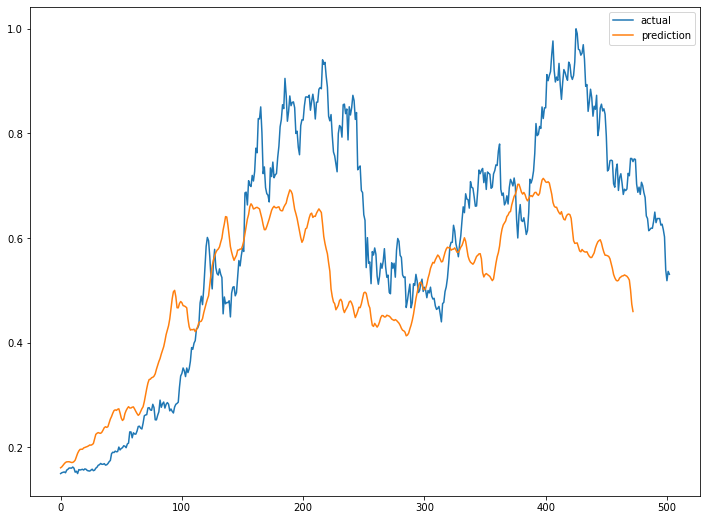

In [67]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            192       
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,617
Trainable params: 3,617
Non-trainable params: 0
_________________________________________________________________
